In [1]:
import pandas as pd
import os
import numpy as np 
import seaborn as sns 

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import StrMethodFormatter
from pyspark.sql.functions import col, skewness, kurtosis
from itertools import product
import itertools

import matplotlib.pyplot as plt 
%matplotlib inline

import plotly.offline as py
from matplotlib import pyplot as plt
from gc import collect as gc_collect
from time import time as t_time
from sklearn.cluster import KMeans

plt.style.use('fivethirtyeight')
py.init_notebook_mode()

def timer():
    print('Time taken: {:.3f}s'.format(t_time()-start))

def dt(date):
    return np.datetime64(date)


In [2]:
df = pd.read_csv(r"C:\Users\Mahek\GunViolenceData\gun_violence_data.csv")
df.head(3)

incident_id        date         state city_or_county  \
0       461105  2013-01-01  Pennsylvania     Mckeesport   
1       460726  2013-01-01    California      Hawthorne   
2       478855  2013-01-01          Ohio         Lorain   

                                     address  n_killed  n_injured  \
0  1506 Versailles Avenue and Coursin Street         0          4   
1               13500 block of Cerise Avenue         1          3   
2                      1776 East 28th Street         1          3   

                                        incident_url  \
0  http://www.gunviolencearchive.org/incident/461105   
1  http://www.gunviolencearchive.org/incident/460726   
2  http://www.gunviolencearchive.org/incident/478855   

                                          source_url  \
0  http://www.post-gazette.com/local/south/2013/0...   
1  http://www.dailybulletin.com/article/zz/201301...   
2  http://chronicle.northcoastnow.com/2013/02/14/...   

   incident_url_fields_missing  ...                    participant_age  \
0                        False  ...                              0::20   
1                        False  ...                              0::20   
2                        False  ...  0::25||1::31||2::33||3::34||4::33   

                               participant_age_group  \
0  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
1  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
2  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   

                            participant_gender  \
0         0::Male||1::Male||3::Male||4::Female   
1                                      0::Male   
2  0::Male||1::Male||2::Male||3::Male||4::Male   

                                    participant_name  \
0                                     0::Julian Sims   
1                                  0::Bernard Gillis   
2  0::Damien Bell||1::Desmen Noble||2::Herman Sea...   

   participant_relationship  \
0                       NaN   
1                       NaN   
2                       NaN   

                                  participant_status  \
0  0::Arrested||1::Injured||2::Injured||3::Injure...   
1      0::Killed||1::Injured||2::Injured||3::Injured   
2  0::Injured, Unharmed, Arrested||1::Unharmed, A...   

                                    participant_type  \
0  0::Victim||1::Victim||2::Victim||3::Victim||4:...   
1  0::Victim||1::Victim||2::Victim||3::Victim||4:...   
2  0::Subject-Suspect||1::Subject-Suspect||2::Vic...   

                                             sources state_house_district  \
0  http://pittsburgh.cbslocal.com/2013/01/01/4-pe...                  NaN   
1  http://losangeles.cbslocal.com/2013/01/01/man-...                 62.0   
2  http://www.morningjournal.com/general-news/201...                 56.0   

  state_senate_district  
0                   NaN  
1                  35.0  
2                  13.0  

[3 rows x 29 columns]

In [3]:
df.shape

(239677, 29)

In [4]:
df.columns

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district'],
      dtype='object')

In [5]:
df.dtypes

incident_id                      int64
date                            object
state                           object
city_or_county                  object
address                         object
n_killed                         int64
n_injured                        int64
incident_url                    object
source_url                      object
incident_url_fields_missing       bool
congressional_district         float64
gun_stolen                      object
gun_type                        object
incident_characteristics        object
latitude                       float64
location_description            object
longitude                      float64
n_guns_involved                float64
notes                           object
participant_age                 object
participant_age_group           object
participant_gender              object
participant_name                object
participant_relationship        object
participant_status              object
participant_type         

In [6]:
drop_name = ['incident_url','source_url']
df.drop(drop_name,axis=1).head(4)

incident_id        date         state city_or_county  \
0       461105  2013-01-01  Pennsylvania     Mckeesport   
1       460726  2013-01-01    California      Hawthorne   
2       478855  2013-01-01          Ohio         Lorain   
3       478925  2013-01-05      Colorado         Aurora   

                                     address  n_killed  n_injured  \
0  1506 Versailles Avenue and Coursin Street         0          4   
1               13500 block of Cerise Avenue         1          3   
2                      1776 East 28th Street         1          3   
3           16000 block of East Ithaca Place         4          0   

   incident_url_fields_missing  congressional_district  \
0                        False                    14.0   
1                        False                    43.0   
2                        False                     9.0   
3                        False                     6.0   

               gun_stolen  ...                    participant_age  \
0                     NaN  ...                              0::20   
1                     NaN  ...                              0::20   
2  0::Unknown||1::Unknown  ...  0::25||1::31||2::33||3::34||4::33   
3                     NaN  ...         0::29||1::33||2::56||3::33   

                               participant_age_group  \
0  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
1  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
2  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
3  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   

                            participant_gender  \
0         0::Male||1::Male||3::Male||4::Female   
1                                      0::Male   
2  0::Male||1::Male||2::Male||3::Male||4::Male   
3         0::Female||1::Male||2::Male||3::Male   

                                    participant_name  \
0                                     0::Julian Sims   
1                                  0::Bernard Gillis   
2  0::Damien Bell||1::Desmen Noble||2::Herman Sea...   
3  0::Stacie Philbrook||1::Christopher Ratliffe||...   

   participant_relationship  \
0                       NaN   
1                       NaN   
2                       NaN   
3                       NaN   

                                  participant_status  \
0  0::Arrested||1::Injured||2::Injured||3::Injure...   
1      0::Killed||1::Injured||2::Injured||3::Injured   
2  0::Injured, Unharmed, Arrested||1::Unharmed, A...   
3         0::Killed||1::Killed||2::Killed||3::Killed   

                                    participant_type  \
0  0::Victim||1::Victim||2::Victim||3::Victim||4:...   
1  0::Victim||1::Victim||2::Victim||3::Victim||4:...   
2  0::Subject-Suspect||1::Subject-Suspect||2::Vic...   
3  0::Victim||1::Victim||2::Victim||3::Subject-Su...   

                                             sources state_house_district  \
0  http://pittsburgh.cbslocal.com/2013/01/01/4-pe...                  NaN   
1  http://losangeles.cbslocal.com/2013/01/01/man-...                 62.0   
2  http://www.morningjournal.com/general-news/201...                 56.0   
3  http://denver.cbslocal.com/2013/01/06/officer-...                 40.0   

  state_senate_district  
0                   NaN  
1                  35.0  
2                  13.0  
3                  28.0  

[4 rows x 27 columns]

In [7]:
df[df.n_killed>5].head(4)


incident_id        date       state city_or_county             address  \
36        482856  2013-03-13    New York         Mohawk        17 W Main St   
57        485811  2013-04-24    Illinois     Manchester         East Street   
95        489581  2013-06-07  California   Santa Monica  2036 Yorkshire Ave   
151       491265  2013-07-26     Florida        Hialeah      1485 W 46th St   

     n_killed  n_injured                                       incident_url  \
36          6          2  http://www.gunviolencearchive.org/incident/482856   
57          6          1  http://www.gunviolencearchive.org/incident/485811   
95          6          1  http://www.gunviolencearchive.org/incident/489581   
151         7          0  http://www.gunviolencearchive.org/incident/491265   

                                            source_url  \
36   http://www.syracuse.com/news/index.ssf/2013/03...   
57   http://fox2now.com/2013/04/25/family-needs-hel...   
95   http://www.huffingtonpost.com/2013/06/07/santa...   
151  https://en.wikipedia.org/wiki/2013_Hialeah_sho...   

     incident_url_fields_missing  ...  \
36                         False  ...   
57                         False  ...   
95                         False  ...   
151                        False  ...   

                                       participant_age  \
36   0::68||1::57||2::66||3::67||4::62||5::51||6::2...   
57                     0::64||1::22||2::29||3::5||4::1   
95     0::55||1::25||2::68||3::26||4::68||5::50||6::23   
151    0::79||1::69||2::33||3::64||4::51||5::17||6::42   

                                 participant_age_group  \
36   0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
57   0::Adult 18+||1::Adult 18+||2::Adult 18+||3::C...   
95   0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
151  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   

                                    participant_gender  \
36   0::Male||1::Male||2::Male||4::Male||5::Male||6...   
57   0::Female||1::Female||2::Male||3::Male||4::Mal...   
95   0::Male||1::Male||2::Male||3::Female||4::Femal...   
151  0::Male||1::Female||2::Male||3::Male||4::Femal...   

                                      participant_name  \
36   0::Harry Montgomery||1::Michael Ransear||2::Jo...   
57   0::Joanne Sinclaire||1::Brittany Luark||2::Roy...   
95   0::Samir "Sam" Zawahri||1::Chris Zawahri||2::C...   
151  0::Italo Pisciotti||1::Samira Pisciotti||2::Ca...   

                      participant_relationship  \
36                              7::Aquaintance   
57   6::Significant others - current or former   
95                                         NaN   
151      6::Mass shooting - Perp Knows Victims   

                                    participant_status  \
36   0::Killed||1::Killed||2::Injured||3::Injured||...   
57   0::Killed||1::Killed||2::Killed||3::Killed||4:...   
95   0::Killed||1::Killed||2::Killed||3::Killed||4:...   
151  0::Killed||1::Killed||2::Killed||3::Killed||4:...   

                                      participant_type  \
36   0::Victim||1::Victim||2::Victim||3::Victim||4:...   
57   0::Victim||1::Victim||2::Victim||3::Victim||4:...   
95   0::Victim||1::Victim||2::Victim||3::Victim||4:...   
151  0::Victim||1::Victim||2::Victim||3::Victim||4:...   

                                               sources state_house_district  \
36   http://www.cbsnews.com/news/upstate-new-york-s...                101.0   
57   http://fox2now.com/2013/04/24/possible-shootin...                100.0   
95   http://www.usatoday.com/story/news/nation/2013...                 50.0   
151  http://www.miamiherald.com/news/special-report...                110.0   

    state_senate_district  
36                   51.0  
57                   50.0  
95                   26.0  
151                  38.0  

[4 rows x 29 columns]

In [8]:
#EXTRACTING STRING INFO FROM STOLEN GUN,TYPE,AGE-GROUP
df["gun_stolen"] = df['gun_stolen'].str.replace("Unknown|[0-9]|[|:]|","")
df["gun_type"]   = df["gun_type"].str.replace("Unknown|[0-9]|[|:]|","")
df["participant_age_group"] = df["participant_age_group"].str.replace("[:|+-]|[0-9]","")

In [9]:
#EXTRACTING YEAR,MONTH,DAY FROM DATE
df["year"] = pd.DatetimeIndex(df["date"]).year
df["month"]= pd.DatetimeIndex(df["date"]).month
df["day"]  = pd.DatetimeIndex(df["date"]).day
df["month"] = df["month"].map({1:"JAN",2:"FEB",3:"MAR",4:"APR",5:"MAY",6:"JUN",7:"JUL",8:"AUG",9:"SEP",10:"OCT",11:"NOV",12:"DEC"})
df["month_year"] = df["month"]+"-"+df["year"].astype(str)

In [10]:
df = df.rename(columns={"n_killed":"killed","n_injured":"injured"})
df = df.sort_values(by="date",ascending=True)

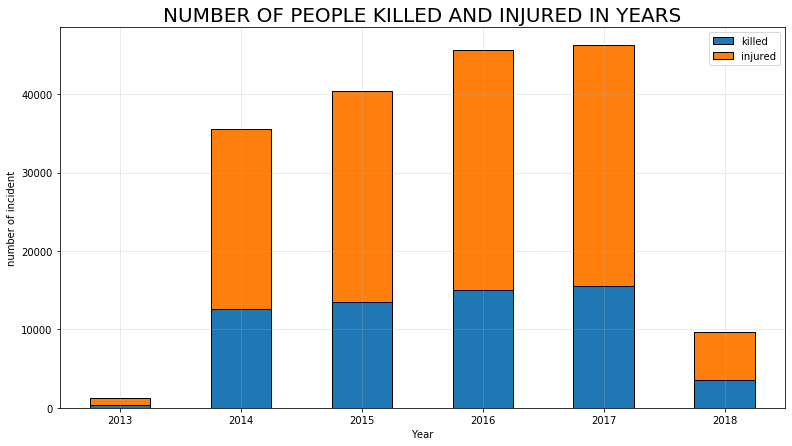

In [11]:
fig = df.groupby("year")[["killed","injured"]].sum().plot(kind="bar",stacked=True,
                                                            figsize=(13,7),
                                                            linewidth = 1,
                                                            edgecolor = "k"*df["year"].nunique())
plt.grid(True,alpha=.3)
plt.xticks(rotation=0)
fig.set_facecolor("white")
plt.legend(prop={"size":10})
plt.title("NUMBER OF PEOPLE KILLED AND INJURED IN YEARS",fontsize = 20)
plt.xlabel('Year')
plt.ylabel('number of incident')

plt.show()

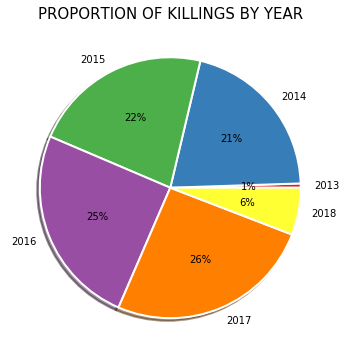

In [12]:
fatalities_year = df.groupby("year")[["killed","injured"]].sum()
fig = plt.figure(figsize=(13,6))
plt.subplot(121)
plt.pie(fatalities_year["killed"],labels=fatalities_year.index,autopct="%1.0f%%",shadow=True,
        colors=sns.color_palette("Set1",7),wedgeprops={"linewidth":2,"edgecolor":"white"})

plt.title("PROPORTION OF KILLINGS BY YEAR",fontsize=15)

fig.set_facecolor("w")

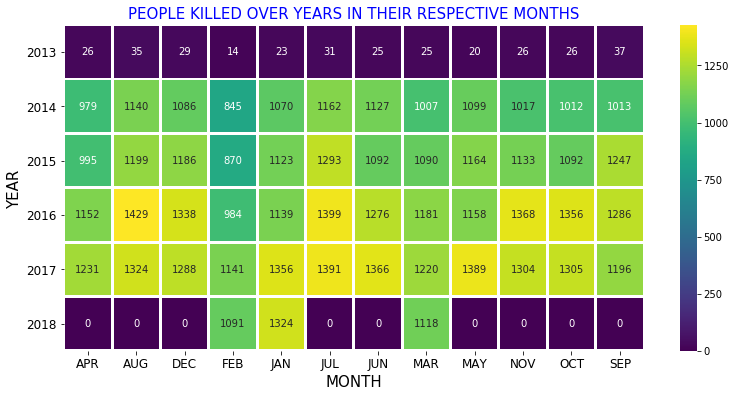

In [13]:
kills_my = pd.pivot_table(index="month",columns="year",data=df,values="killed",aggfunc="sum").fillna(0)

for i in kills_my.columns:
    kills_my[i] = kills_my[i].astype(np.int64)
plt.figure(figsize=(13,6))
fig = sns.heatmap(kills_my.transpose(),cmap="viridis",
                  annot=True,fmt="d",linecolor="white",linewidths=2)
plt.xticks(fontsize =12)
plt.yticks(fontsize =12,rotation=0)
plt.ylabel("YEAR",fontsize=15)
plt.xlabel("MONTH",fontsize=15)
plt.title("PEOPLE KILLED OVER YEARS IN THEIR RESPECTIVE MONTHS",fontsize=15,color="b")
plt.show()

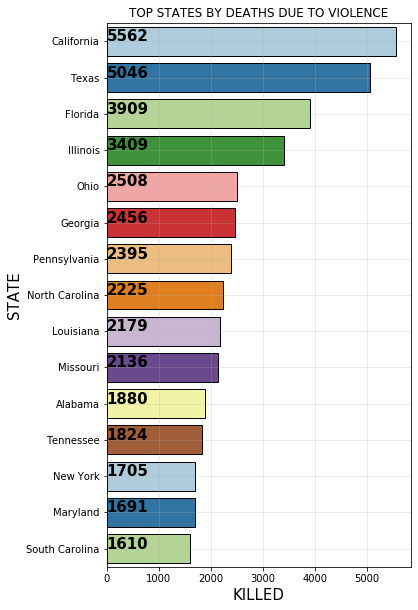

In [14]:
state_kill   = df.groupby("state")["killed"].sum().reset_index().sort_values(by="killed",ascending=False)
fig = plt.figure(figsize=(12,10))
plt.subplot(121)
ax = sns.barplot("killed","state",
                 data=state_kill[:15],palette="Paired",
                 linewidth=1,edgecolor = "k"*15)
plt.ylabel("STATE",fontsize=15)
plt.xlabel("KILLED",fontsize=15)
plt.title("TOP STATES BY DEATHS DUE TO VIOLENCE")
for i,j in enumerate(state_kill["killed"][:15]):
    ax.text(.9,i,j,weight="bold",fontsize=15)
plt.grid(True,alpha= .3)    
fig.set_facecolor("w")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239677 entries, 0 to 239676
Data columns (total 33 columns):
incident_id                    239677 non-null int64
date                           239677 non-null object
state                          239677 non-null object
city_or_county                 239677 non-null object
address                        223180 non-null object
killed                         239677 non-null int64
injured                        239677 non-null int64
incident_url                   239677 non-null object
source_url                     239209 non-null object
incident_url_fields_missing    239677 non-null bool
congressional_district         227733 non-null float64
gun_stolen                     140179 non-null object
gun_type                       140226 non-null object
incident_characteristics       239351 non-null object
latitude                       231754 non-null float64
location_description           42089 non-null object
longitude                    

In [16]:
df.describe()

incident_id         killed        injured  congressional_district  \
count  2.396770e+05  239677.000000  239677.000000           227733.000000   
mean   5.593343e+05       0.252290       0.494007                8.001265   
std    2.931287e+05       0.521779       0.729952                8.480835   
min    9.211400e+04       0.000000       0.000000                0.000000   
25%    3.085450e+05       0.000000       0.000000                2.000000   
50%    5.435870e+05       0.000000       0.000000                5.000000   
75%    8.172280e+05       0.000000       1.000000               10.000000   
max    1.083472e+06      50.000000      53.000000               53.000000   

            latitude      longitude  n_guns_involved  state_house_district  \
count  231754.000000  231754.000000    140226.000000         200905.000000   
mean       37.546598     -89.338348         1.372442             55.447132   
std         5.130763      14.359546         4.678202             42.048117   
min        19.111400    -171.429000         1.000000              1.000000   
25%        33.903400     -94.158725         1.000000             21.000000   
50%        38.570600     -86.249600         1.000000             47.000000   
75%        41.437375     -80.048625         1.000000             84.000000   
max        71.336800      97.433100       400.000000            901.000000   

       state_senate_district           year            day  
count           207342.00000  239677.000000  239677.000000  
mean                20.47711    2015.711629      15.773787  
std                 14.20456       1.225870       8.831929  
min                  1.00000    2013.000000       1.000000  
25%                  9.00000    2015.000000       8.000000  
50%                 19.00000    2016.000000      16.000000  
75%                 30.00000    2017.000000      23.000000  
max                 94.00000    2018.000000      31.000000

In [17]:
df.describe(include=["O"])

date     state city_or_county                  address  \
count       239677    239677         239677                   223180   
unique        1725        51          12898                   198037   
top     2017-01-01  Illinois        Chicago  2375 International Pkwy   
freq           342     17556          10814                      160   

                                             incident_url  \
count                                              239677   
unique                                             239677   
top     http://www.gunviolencearchive.org/incident/140578   
freq                                                    1   

                 source_url gun_stolen gun_type incident_characteristics  \
count                239209     140179   140226                   239351   
unique               213989         81     1790                    18126   
top     http://blog.tsa.gov                       Shot - Wounded/Injured   
freq                   1092     131304    97988                    47541   

       location_description  ... participant_age participant_age_group  \
count                 42089  ...          147379                197558   
unique                27595  ...           18951                   512   
top                  Austin  ...           0::24                Adult    
freq                    240  ...            3814                100316   

       participant_gender participant_name  \
count              203315           117424   
unique                873           113488   
top               0::Male       0::Officer   
freq                93496              144   

                         participant_relationship participant_status  \
count                                       15774             212051   
unique                                        284               2150   
top     1::Significant others - current or former         0::Injured   
freq                                         2651              42293   

       participant_type              sources   month month_year  
count            214814               239068  239677     239677  
unique              259               217280      12         63  
top           0::Victim  http://blog.tsa.gov     JAN   MAY-2017  
freq              58564                 1092   23091       5666  

[4 rows x 21 columns]

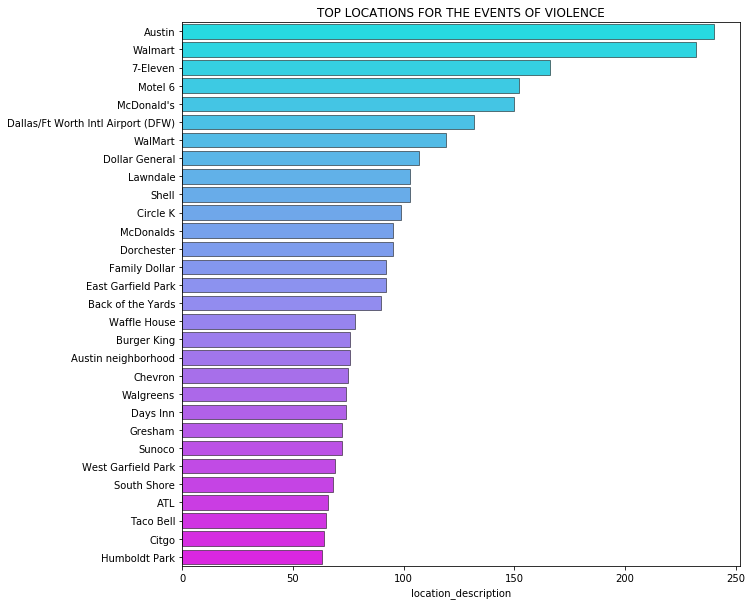

In [18]:
location = df[df['location_description'].notnull()]["location_description"].value_counts()[:30]
location = pd.DataFrame(location).reset_index()
plt.figure(figsize=(10,10))
sns.barplot(y=location["index"],x=location["location_description"],palette="cool",
            linewidth = .5 , edgecolor = "k"*30 )
plt.ylabel("")
plt.title("TOP LOCATIONS FOR THE EVENTS OF VIOLENCE")
plt.show()

In [19]:
df.head()

incident_id        date           state city_or_county  \
0       461105  2013-01-01    Pennsylvania     Mckeesport   
1       460726  2013-01-01      California      Hawthorne   
2       478855  2013-01-01            Ohio         Lorain   
3       478925  2013-01-05        Colorado         Aurora   
4       478959  2013-01-07  North Carolina     Greensboro   

                                     address  killed  injured  \
0  1506 Versailles Avenue and Coursin Street       0        4   
1               13500 block of Cerise Avenue       1        3   
2                      1776 East 28th Street       1        3   
3           16000 block of East Ithaca Place       4        0   
4                  307 Mourning Dove Terrace       2        2   

                                        incident_url  \
0  http://www.gunviolencearchive.org/incident/461105   
1  http://www.gunviolencearchive.org/incident/460726   
2  http://www.gunviolencearchive.org/incident/478855   
3  http://www.gunviolencearchive.org/incident/478925   
4  http://www.gunviolencearchive.org/incident/478959   

                                          source_url  \
0  http://www.post-gazette.com/local/south/2013/0...   
1  http://www.dailybulletin.com/article/zz/201301...   
2  http://chronicle.northcoastnow.com/2013/02/14/...   
3  http://www.dailydemocrat.com/20130106/aurora-s...   
4  http://www.journalnow.com/news/local/article_d...   

   incident_url_fields_missing  ...  participant_relationship  \
0                        False  ...                       NaN   
1                        False  ...                       NaN   
2                        False  ...                       NaN   
3                        False  ...                       NaN   
4                        False  ...                 3::Family   

                                  participant_status  \
0  0::Arrested||1::Injured||2::Injured||3::Injure...   
1      0::Killed||1::Injured||2::Injured||3::Injured   
2  0::Injured, Unharmed, Arrested||1::Unharmed, A...   
3         0::Killed||1::Killed||2::Killed||3::Killed   
4       0::Injured||1::Injured||2::Killed||3::Killed   

                                    participant_type  \
0  0::Victim||1::Victim||2::Victim||3::Victim||4:...   
1  0::Victim||1::Victim||2::Victim||3::Victim||4:...   
2  0::Subject-Suspect||1::Subject-Suspect||2::Vic...   
3  0::Victim||1::Victim||2::Victim||3::Subject-Su...   
4  0::Victim||1::Victim||2::Victim||3::Subject-Su...   

                                             sources  state_house_district  \
0  http://pittsburgh.cbslocal.com/2013/01/01/4-pe...                   NaN   
1  http://losangeles.cbslocal.com/2013/01/01/man-...                  62.0   
2  http://www.morningjournal.com/general-news/201...                  56.0   
3  http://denver.cbslocal.com/2013/01/06/officer-...                  40.0   
4  http://myfox8.com/2013/01/08/update-mother-sho...                  62.0   

  state_senate_district  year  month day month_year  
0                   NaN  2013    JAN   1   JAN-2013  
1                  35.0  2013    JAN   1   JAN-2013  
2                  13.0  2013    JAN   1   JAN-2013  
3                  28.0  2013    JAN   5   JAN-2013  
4                  27.0  2013    JAN   7   JAN-2013  

[5 rows x 33 columns]

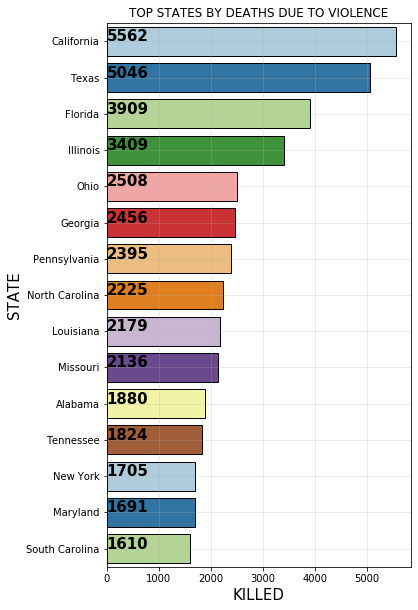

In [20]:
state_kill   = df.groupby("state")["killed"].sum().reset_index().sort_values(by="killed",ascending=False)
fig = plt.figure(figsize=(12,10))
plt.subplot(121)
ax = sns.barplot("killed","state",
                 data=state_kill[:15],palette="Paired",
                 linewidth=1,edgecolor = "k"*15)
plt.ylabel("STATE",fontsize=15)
plt.xlabel("KILLED",fontsize=15)
plt.title("TOP STATES BY DEATHS DUE TO VIOLENCE")
for i,j in enumerate(state_kill["killed"][:15]):
    ax.text(.9,i,j,weight="bold",fontsize=15)
plt.grid(True,alpha= .3)    
fig.set_facecolor("w")

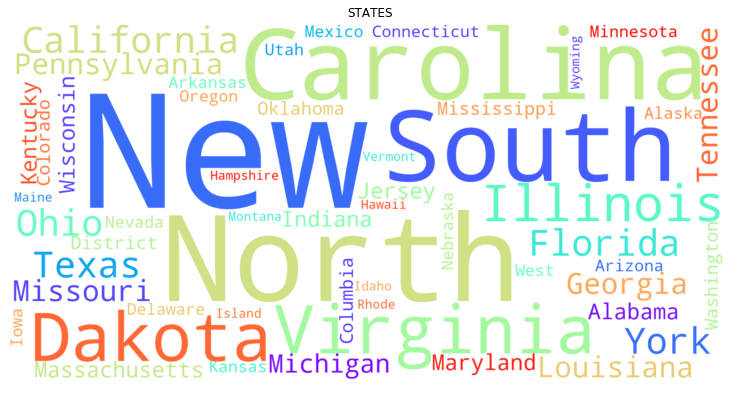

In [21]:


words = df["state"].value_counts().keys()
wc = WordCloud(max_words=60,scale=5,colormap="rainbow",background_color="white").generate(" ".join(words))
plt.figure(figsize=(13,8))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.title("STATES")
plt.show()

C:\Users\Mahek\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


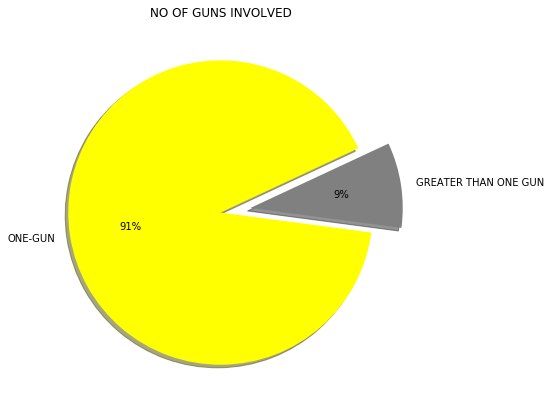

In [22]:
n_guns = df.loc[df["n_guns_involved"].notnull()]
n_guns["n_guns_involved"] = n_guns["n_guns_involved"].astype(int)
n_guns = n_guns[["n_guns_involved"]]

def label(n_guns):
    if n_guns["n_guns_involved"] == 1 :
        return "ONE-GUN"
    elif n_guns["n_guns_involved"] > 1 :
        return "GREATER THAN ONE GUN"

n_guns["x"] = n_guns.apply(lambda n_guns:label(n_guns),axis=1)
n_guns["x"].value_counts().plot.pie(figsize=(7,7),autopct ="%1.0f%%",explode = [0,.2],shadow = True,colors=["yellow","grey"],startangle =25)
plt.title("NO OF GUNS INVOLVED")
plt.ylabel("")
plt.show()

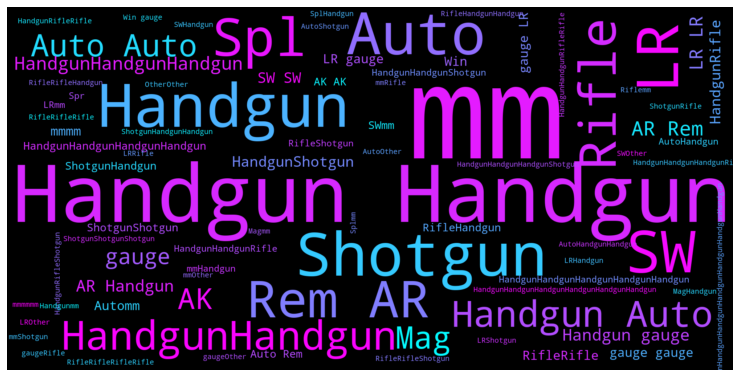

In [23]:
gn = df[df["gun_type"].notnull()]
w = WordCloud(background_color="black",colormap="cool",scale=5).generate(" ".join(gn["gun_type"]))
plt.figure(figsize=(13,8))
plt.imshow(w,interpolation="bilinear")
plt.axis("off")
plt.show()

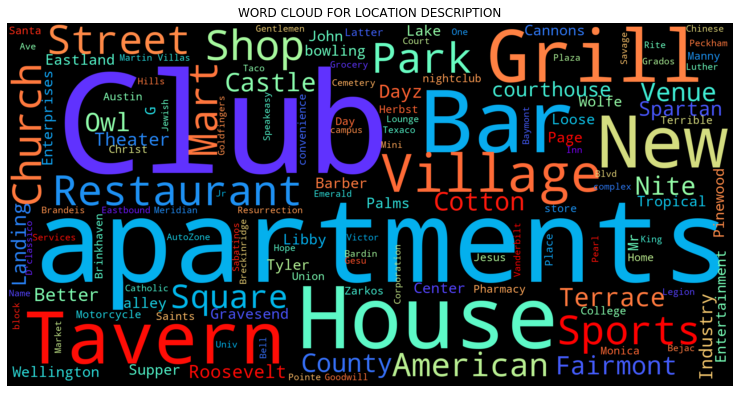

In [24]:
location = df[df['location_description'].notnull()]["location_description"].value_counts().keys()
wc2 =WordCloud(scale = 5,background_color="black",colormap="rainbow").generate(str(df[df["location_description"].notnull()]["location_description"]))
plt.figure(figsize=(13,8))
plt.imshow(wc2,interpolation="bilinear")
plt.axis("off")
plt.title("WORD CLOUD FOR LOCATION DESCRIPTION")
plt.show()

In [25]:
age = df[df["participant_age"].notnull()][["participant_age"]]
age["participant_age"] = age["participant_age"].str.replace("::","-")
age["participant_age"] = age["participant_age"].str.replace(":","-")
age["participant_age"] = age["participant_age"].str.replace("[||]",",")
age = pd.DataFrame(age["participant_age"])
x1 = pd.DataFrame(age["participant_age"].str.split(",").str[0])
x2 = pd.DataFrame(age["participant_age"].str.split(",").str[1])
x3 = pd.DataFrame(age["participant_age"].str.split(",").str[2])
x4 = pd.DataFrame(age["participant_age"].str.split(",").str[3])
x5 = pd.DataFrame(age["participant_age"].str.split(",").str[4])
x6 = pd.DataFrame(age["participant_age"].str.split(",").str[5])
x7 = pd.DataFrame(age["participant_age"].str.split(",").str[6])
x1 = x1[x1["participant_age"].notnull()]
x2 = x2[x2["participant_age"].notnull()]
x3 = x3[x3["participant_age"].notnull()]
x4 = x4[x4["participant_age"].notnull()]
x5 = x5[x5["participant_age"].notnull()]
x6 = x6[x6["participant_age"].notnull()]
x7 = x7[x7["participant_age"].notnull()]

age_dec  = pd.concat([x1,x2,x3,x4,x5,x6,x7],axis = 0)
age_dec["lwr_lmt"] = age_dec["participant_age"].str.split("-").str[0]
age_dec["upr_lmt"] = age_dec["participant_age"].str.split("-").str[1]
age_dec.head()

age_dec= age_dec[age_dec["lwr_lmt"]!='']
age_dec["lwr_lmt"] = age_dec["lwr_lmt"].astype(int)
age_dec["upr_lmt"] = age_dec["upr_lmt"].astype(int)

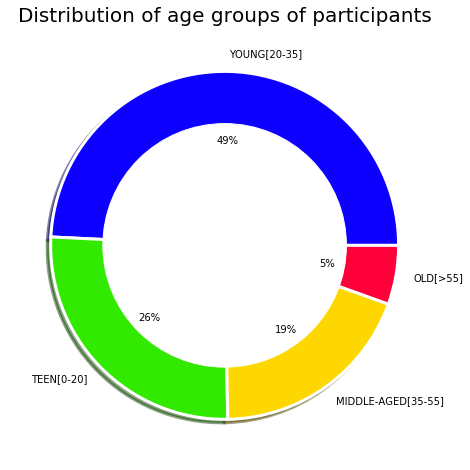

In [26]:
age_dec["age_bins"] = pd.cut(age_dec["upr_lmt"],bins=[0,20,35,55,130],labels=["TEEN[0-20]","YOUNG[20-35]","MIDDLE-AGED[35-55]","OLD[>55]"])
plt.figure(figsize=(8,8))
age_dec["age_bins"].value_counts().plot.pie(autopct = "%1.0f%%",shadow =True,startangle = 0,colors = sns.color_palette("prism",5),
                                            wedgeprops = {"linewidth" :3,"edgecolor":"w"})
my_circ = plt.Circle((0,0),.7,color = "white")
plt.gca().add_artist(my_circ)
plt.ylabel("")
plt.title("Distribution of age groups of participants",fontsize=20)
plt.show()

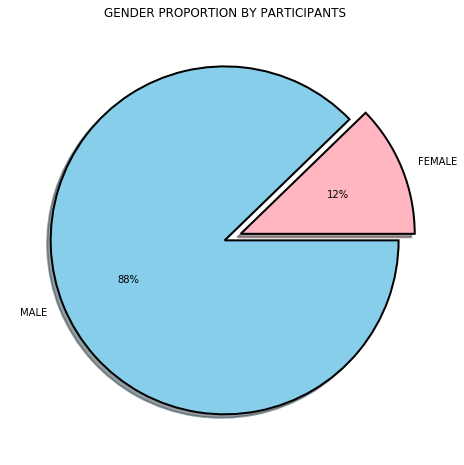

In [27]:
gender = df["participant_gender"].str.replace("[::0-9|]","").str.upper()
gender = gender.str.replace("FEMALE","F")
gender = gender.str.replace("MALE","M")
gender = pd.DataFrame(gender)
gender = gender[gender["participant_gender"].notnull()]
gender["female"] = gender["participant_gender"].str.count("F")
gender["male"]   = gender["participant_gender"].str.count("M")
size = [sum(gender["female"]),sum(gender["male"])]
plt.figure(figsize=(8,8))
plt.pie(size,labels=["FEMALE","MALE"],shadow=True,colors=["lightpink","skyblue"],autopct="%1.0f%%",wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.1,0])
plt.title("GENDER PROPORTION BY PARTICIPANTS")
plt.show()

In [3]:
start = t_time()

incidents = pd.read_csv('C:/Users/Mahek/Desktop/clustering/gun-violence-data_01-2013_03-2018.csv',
                        parse_dates=['date'],
                        usecols=['date', 'state', 'city_or_county', 'n_killed', 'n_injured', 'longitude', 'latitude']
                       ).rename(columns={'city_or_county':'city'})

incidents['city'] = incidents['city'].apply(lambda x: x.replace('(county)', '').replace(' County', ''))

timer()

incidents.head()

Time taken: 2.400s


date           state        city  n_killed  n_injured  latitude  \
0 2013-01-01    Pennsylvania  Mckeesport         0          4   40.3467   
1 2013-01-01      California   Hawthorne         1          3   33.9090   
2 2013-01-01            Ohio      Lorain         1          3   41.4455   
3 2013-01-05        Colorado      Aurora         4          0   39.6518   
4 2013-01-07  North Carolina  Greensboro         2          2   36.1140   

   longitude  
0   -79.8559  
1  -118.3330  
2   -82.1377  
3  -104.8020  
4   -79.9569

In [4]:
start = t_time()

state_codes = {
    'Alabama' : 'AL',
    'Alaska' : 'AK',
    'Arizona' : 'AZ',
    'Arkansas' : 'AR',
    'California' : 'CA',
    'Colorado' : 'CO',
    'Connecticut' : 'CT',
    'Delaware' : 'DE',
    'District of Columbia' : 'DC',
    'Florida' : 'FL',
    'Georgia' : 'GA',
    'Hawaii' : 'HI',
    'Idaho' : 'ID',
    'Illinois' : 'IL',
    'Indiana' : 'IN',
    'Iowa' : 'IA',
    'Kansas' : 'KS',
    'Kentucky' : 'KY',
    'Louisiana' : 'LA',
    'Maine' : 'ME',
    'Maryland' : 'MD',
    'Massachusetts' : 'MA',
    'Michigan' : 'MI',
    'Minnesota' : 'MN',
    'Mississippi' : 'MS',
    'Missouri' : 'MO',
    'Montana' : 'MT',
    'Nebraska' : 'NE',
    'Nevada' : 'NV',
    'New Hampshire' : 'NH',
    'New Jersey' : 'NJ',
    'New Mexico' : 'NM',
    'New York' : 'NY',
    'North Carolina' : 'NC',
    'North Dakota' : 'ND',
    'Ohio' : 'OH',
    'Oklahoma' : 'OK',
    'Oregon' : 'OR',
    'Pennsylvania' : 'PA',
    'Puerto Rico' : 'PR',
    'Rhode Island' : 'RI',
    'South Carolina' : 'SC',
    'South Dakota' : 'SD',
    'Tennessee' : 'TN',
    'Texas' : 'TX',
    'Utah' : 'UT',
    'Vermont' : 'VT',
    'Virginia' : 'VA',
    'Washington' : 'WA',
    'West Virginia' : 'WV',
    'Wisconsin' : 'WI',
    'Wyoming' : 'WY'
}

census = pd.read_csv('C:/Users/Mahek/Desktop/clustering/us-census-demographic-data/acs2015_county_data.csv', usecols=['State', 'TotalPop']).rename(columns={'State':'state', 'TotalPop':'population'})
census = census.groupby('state').sum().reset_index()
census['state_code'] = census['state'].apply(lambda x: state_codes[x])

timer()

census.head()

Time taken: 0.027s


state  population state_code
0     Alabama     4830620         AL
1      Alaska      733375         AK
2     Arizona     6641928         AZ
3    Arkansas     2958208         AR
4  California    38421464         CA

In [5]:
start = t_time()
areas = pd.read_csv('C:/Users/Mahek/Desktop/clustering/usa-areas.csv')
timer()
areas.head()

Time taken: 0.005s


state      area
0      Alaska  663267.0
1       Texas  268581.0
2  California  163696.0
3     Montana  147042.0
4  New Mexico  121589.0

In [6]:
start = t_time()

N_CLUSTERS = 250

incidents = incidents[(incidents['longitude'].notna()) & (incidents['longitude'].notna())].reset_index(drop=True)

incidents['cluster'] = KMeans(N_CLUSTERS, n_init=2, max_iter=50, random_state=42).fit_predict(incidents[['longitude', 'latitude']])
incidents_groupby_cluster = incidents[['state', 'city', 'longitude', 'latitude', 'n_injured', 'n_killed', 'cluster']].groupby('cluster')

incidents_by_cluster = incidents_groupby_cluster.sum().reset_index(drop=True)
incidents_by_cluster['longitude'] = incidents_groupby_cluster.mean()[['longitude']]
incidents_by_cluster['latitude'] = incidents_groupby_cluster.mean()[['latitude']]

timer()

Time taken: 71.024s


In [7]:
def join_names(names):
    return '/'.join([name for name in sorted(set(names))])

incidents_by_cluster['states'] = incidents_groupby_cluster['state'].apply(join_names)
incidents_by_cluster['severity'] = (2*incidents_by_cluster['n_killed']+incidents_by_cluster['n_injured'])**0.3
incidents_by_cluster['death_pct'] = incidents_by_cluster['n_killed']/(incidents_by_cluster['n_killed']+incidents_by_cluster['n_injured'])
incidents_by_cluster.sort_values(by=['severity', 'death_pct'], inplace=True)

data = [ dict(
    type = 'scattergeo',
    lon = incidents_by_cluster['longitude'],
    lat = incidents_by_cluster['latitude'],
    text = '<br><b>States</b><br>'+incidents_by_cluster['states']
        +'<br><br><b>Longitude</b><br>'+incidents_by_cluster['longitude'].apply(str)
        +'<br><br><b>Latitude</b><br>'+incidents_by_cluster['latitude'].apply(str)
        +'<br><br><b>Injuries</b><br>'+incidents_by_cluster['n_injured'].apply(str)
        +'<br><br><b>Deaths</b><br>'+incidents_by_cluster['n_killed'].apply(str),
    marker = dict(
        size = 3*incidents_by_cluster['severity'],
        line = dict(
            width = 0.5
        ),
        cmin = incidents_by_cluster['severity'].min(),
        color = incidents_by_cluster['severity'],
        cmax = incidents_by_cluster['severity'].max(),
        opacity = 0.95,
    )
)]

layout = dict(
    title = 'Focuses of violence',
    geo = dict(
        scope = 'usa'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig)